# Predicting 2021 OBP from players' performance in previous years 

## Tools

### Data

We have each players' number of plate appearances and OBP for the past 5 years, as well as his age.

In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# parse data into correct pandas types
df = pd.read_csv('obp.csv').fillna(0).set_index('playerid')
df['birth_date'] = pd.to_datetime(df['birth_date'])
now = datetime.datetime.now()
df['age_days'] = df['birth_date'].apply(lambda birth_date: (now - birth_date) / pd.Timedelta('1day'))

# keep 2021 data in a different dataframe to avoid lookahead bias
df_2021 = df[['PA_21', 'OBP_21']]
df.drop(['PA_21', 'OBP_21'], axis='columns', inplace=True)

df.head(20)

,Name,birth_date,PA_20,OBP_20,PA_19,OBP_19,PA_18,OBP_18,PA_17,OBP_17,PA_16,OBP_16,age_days
playerid,,,,,,,,,,,,,
9952,Trayce Thompson,1991-03-15,0.0,0.000,0.0,0.000,137.0,0.162,55.0,0.218,262.0,0.302,11907.999168
10155,Mike Trout,1991-08-07,241.0,0.390,600.0,0.438,608.0,0.460,507.0,0.442,681.0,0.441,11762.999168
11579,Bryce Harper,1992-10-16,244.0,0.420,682.0,0.372,695.0,0.393,492.0,0.413,627.0,0.373,11326.999168
10030,Chris Owings,1991-08-12,44.0,0.318,196.0,0.209,309.0,0.272,386.0,0.299,466.0,0.315,11757.999168
21538,Nick Fortes,1996-11-11,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.000,9839.999168
20123,Juan Soto,1998-10-25,196.0,0.490,659.0,0.401,494.0,0.406,0.0,0.000,0.0,0.000,9126.999168
19611,Vladimir Guerrero Jr.,1999-03-16,243.0,0.329,514.0,0.339,0.0,0.000,0.0,0.000,0.0,0.000,8984.999168
14161,Byron Buxton,1993-12-18,135.0,0.267,295.0,0.314,94.0,0.183,511.0,0.314,331.0,0.284,10898.999168
18401,Ronald Acuna Jr.,1997-12-18,202.0,0.406,715.0,0.365,487.0,0.366,0.0,0.000,0.0,0.000,9437.999168


### Error metrics

Two metrics were used for evaluating the accuracy of predictions for 2021 OBP against the actual target values: mean absolute error and root mean squared error.

In [2]:
def mean_abs_error(y_pred, y_test):
    error = (y_test - y_pred).abs().mean()
    return error

def root_mean_squared_error(y_pred, y_test):
    error = np.sqrt(((y_pred - y_test)**2).mean())
    return error

## Model 1: The simplest prediction of a player's 2021 OBP is his OBP prior to 2021.

### Calculation of total statistics from what we have available before 2021

In [3]:
# total plate appearances
df['PA_total'] = df[[f'PA_{year}' for year in range(16, 21)]].sum(axis='columns')

# Filter out players for whom we don't have any data
df = df[df['PA_total'] > 0]

# total OBP, weighting each year's OBP by that year's number of plate appearances
df['OBP_total'] = pd.concat([df[f'PA_{year}'] * df[f'OBP_{year}'] for year in range(16, 21)],
                             axis='columns').sum(axis='columns') \
                      / df['PA_total']

We don't have any data on players without any plate appearances between 2016-2020, so we can't use any model to predict their 2021 OBP. A good prediction for these players' 2021 OBP would be the historical average rookie OBP.

### Results and evaluation

All models were tested on three different datasets with varying levels of noise. The first dataset contains every player with at least one plate appearance from 2016-2020. The second contains every player with at least 100 plate appearances from 2016-2020, which removes the players for whom we have too little data to make informed predictions. The third dataset contains every player with at least 100 plate appearances in both the period of 2016-2020 and in 2021. This removes the players for whom we have too little data to properly evaluate our predictions. The expectation is that the models' performance improves from the first to the third dataset.

The error metrics for Model 1's predictions against all three datasets are shown below.

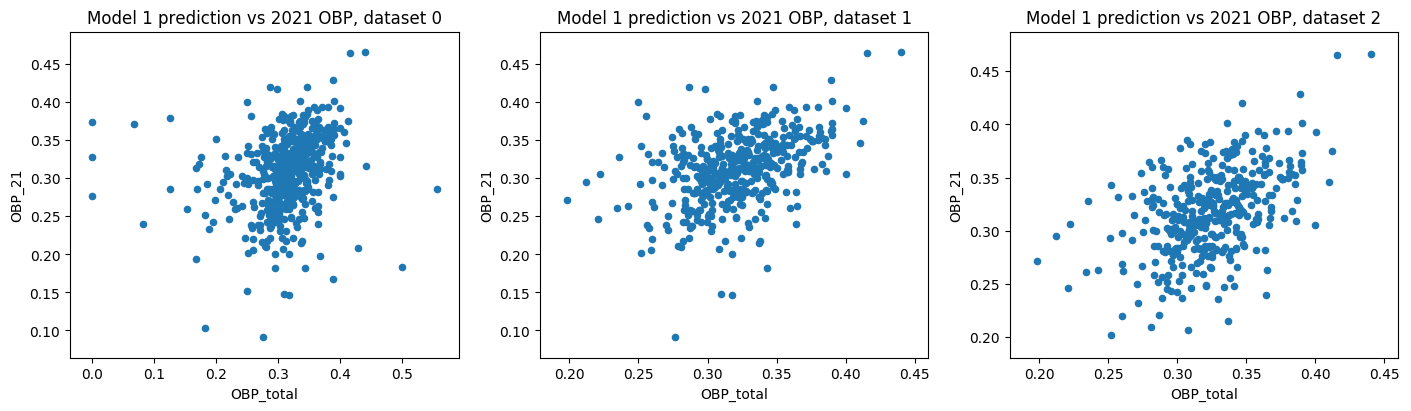

In [4]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 4), constrained_layout=True)
test = df.merge(df_2021, left_index=True, right_index=True)
subsets = [test.index, test['PA_total'] >= 100, (test['PA_total'] >= 100) & (test['PA_21'] >= 100)]

model1_evals = []
for i, subset in enumerate(subsets):
    model1_res = test.loc[subset]
    mae = mean_abs_error(model1_res['OBP_total'], model1_res['OBP_21'])
    rmse = root_mean_squared_error(model1_res['OBP_total'], model1_res['OBP_21'])
    model1_res.plot.scatter(x='OBP_total', y='OBP_21', title=f'Model 1 prediction vs 2021 OBP, dataset {i}', ax=ax[i])
    model1_evals.append([i, mae, rmse, len(model1_res)])

Performance improves from the first to the third dataset, as expected.

In [5]:
eval_columns = ['data_subset', 'mean_absolute_error', 'root_mean_squared_error', 'count_data_points']
model1_eval = pd.DataFrame(model1_evals, columns=eval_columns)
model1_eval

,data_subset,mean_absolute_error,root_mean_squared_error,count_data_points
0,0,0.043681,0.064201,506
1,1,0.034724,0.045534,431
2,2,0.030872,0.038872,381


## Model 2: Linear regression on past four years of OBP

### Ideas for improvement upon Model 1

Model 1 does not consider any element of recency in its predictions, instead using each plate appearance as an equally weighted input. To improve upon this, Model 2 consolidates plate appearances by season before using them as inputs, allowing different weight to be assigned to more recent performance. The mathematical tool of linear regression can be used to find the optimal weight for each year and output predictions based on them.

To make its predictions, Model 2 regresses the past four years' OBP's on the following year's OBP. Its coefficients were obtained using 2016-2019 as training data for the target of 2020. It was then evaluated by using the obtained coefficients on 2017-2020 to make predictions for 2021.

Three modifications to the training data were made to remove unnecessary noise. The first was that any year's OBP for which a player had less than 50 plate appearances was replaced with that player's total OBP from 2016-2019. These data were treated as if missing and needed interpolation, because a season with so few plate appearances was likely cut short by injury or roster changes and may not accurately represent player ability. The second was to remove players with any more than two such seasons. This was to avoid training the model on players for whom half or more data was interpolated. The third was to remove players with less than 50 plate appearances in 2020. This was to remove noise in the labels.

### Results and evaluation

The error metrics for Model 2's predictions against all three datasets are shown below. Model 2 consistently outperforms Model 1.

/tmp/ipykernel_122903/1029873066.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model2_res['pred'] = lr.predict(model2_res[feature_cols])
/tmp/ipykernel_122903/1029873066.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model2_res['pred'] = lr.predict(model2_res[feature_cols])


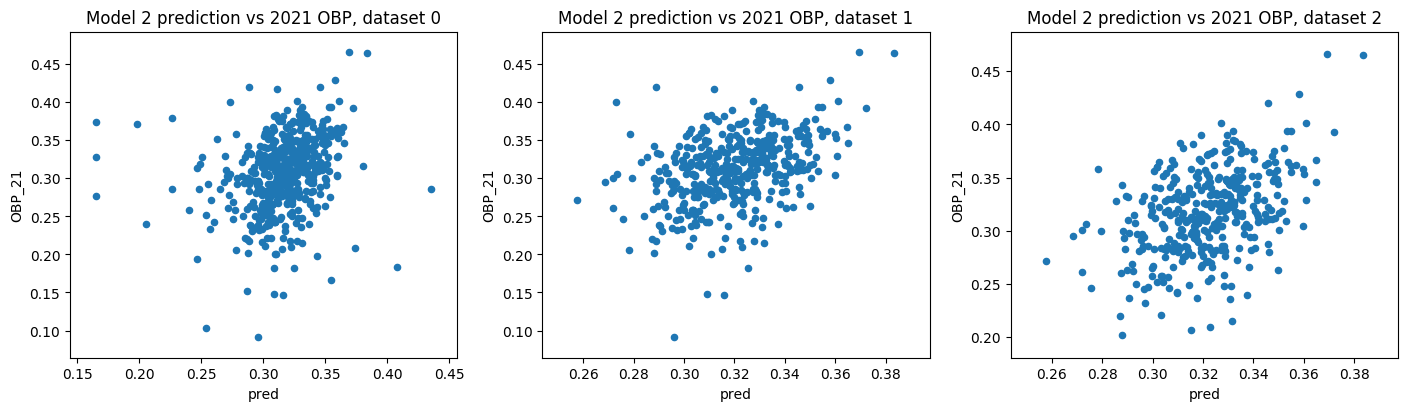

In [6]:
import sklearn.linear_model

fig, ax = plt.subplots(ncols=3, figsize=(14, 4), constrained_layout=True)

min_season_pa = 50

interpolated = df.copy()

# avoid lookahead bias by using 2016-2019 total OBP for interpolation, rather than 2016-2020
interpolated['OBP_total_train'] = pd.concat([df[f'PA_{year}'] * df[f'OBP_{year}'] for year in range(16, 20)],
                                         axis='columns').sum(axis='columns') \
                                  / df['PA_total']

#interpolation
for year in range(16, 20):
    year_slice = interpolated[f'PA_{year}'] < min_season_pa
    interpolated.loc[year_slice, f'OBP_{year}'] = interpolated.loc[year_slice, 'OBP_total_train']
    
feature_cols = [f'OBP{i}' for i in range(4)]
# second and third modifications to training data
train_slice = (interpolated['PA_20'] >= min_season_pa) & (pd.concat([interpolated[f'PA_{year}'] < min_season_pa for year in range(16, 20)], axis='columns').sum(axis='columns') <= 2)
X_train = interpolated.loc[train_slice, [f'OBP_{year}' for year in range(16, 20)]]
X_train.rename(columns={f'OBP_{year}' : f'OBP{i}' for i, year in enumerate(range(16, 20))}, inplace=True)
y_train = interpolated[['OBP_20']]
train = X_train.merge(y_train, left_index=True, right_index=True)
lr = sklearn.linear_model.LinearRegression(fit_intercept=True).fit(X_train[feature_cols], train['OBP_20'])

# use 2016-2020 total OBP for interpolation for the target of 2021, as 2020 data no longer introduces lookahead bias
for year in range(16, 21):
    year_slice = interpolated[f'PA_{year}'] < min_season_pa
    interpolated.loc[year_slice, f'OBP_{year}'] = interpolated.loc[year_slice, 'OBP_total']

# use coefficients learned from 2016-2019 training set on 2017-2020
test = interpolated[[f'OBP_{year}' for year in range(17, 21)] + ['PA_total']].merge(df_2021, left_index=True, right_index=True)
test.rename(columns={f'OBP_{year}' : f'OBP{i}' for i, year in enumerate(range(17, 21))}, inplace=True)
subsets = [test.index, test['PA_total'] >= 100, (test['PA_total'] >= 100) & (test['PA_21'] >= 100)]
model2_evals = []
for i, subset in enumerate(subsets):
    model2_res = test.loc[subset]
    model2_res['pred'] = lr.predict(model2_res[feature_cols])
    mae = mean_abs_error(model2_res['pred'], model2_res['OBP_21'])
    rmse = root_mean_squared_error(model2_res['pred'], model2_res['OBP_21'])
    model2_res.plot.scatter(x='pred', y='OBP_21', title=f'Model 2 prediction vs 2021 OBP, dataset {i}', ax=ax[i])
    model2_evals.append([i, mae, rmse, len(model2_res)])

In [7]:
model2_eval = pd.DataFrame(model2_evals, columns=eval_columns)
model1_eval['model'] = 1
model2_eval['model'] = 2
pd.concat([model1_eval, model2_eval])[['model'] + eval_columns].sort_values('data_subset').sort_values('data_subset')

,model,data_subset,mean_absolute_error,root_mean_squared_error,count_data_points
0,1,0,0.043681,0.064201,506
0,2,0,0.036967,0.050799,506
1,1,1,0.034724,0.045534,431
1,2,1,0.032627,0.043265,431
2,1,2,0.030872,0.038872,381
2,2,2,0.028591,0.036229,381


The regression coefficients also show that more recent plate appearances have more predictive power, which is consistent with the expectation.

In [8]:
pd.DataFrame({'years_ago': [len(lr.coef_) - i for i in range(len(lr.coef_))], 'regression_coefficient': lr.coef_})

,years_ago,regression_coefficient
0,4,-0.136379
1,3,0.205575
2,2,0.145183
3,1,0.271392


## Model 3: Ridge regression, plus two extra feature

### Ideas for improvement upon Model 2

Model 2 appears to have highly correlated features, especially after interpolating noisy data points. Here is the correlation matrix before interpolation:

In [9]:
df[[f'OBP_{year}' for year in range(16, 21)]].corr()

,OBP_16,OBP_17,OBP_18,OBP_19,OBP_20
OBP_16,1.000000,0.735370,0.588188,0.348244,0.094340
OBP_17,0.735370,1.000000,0.719613,0.428344,0.223743
OBP_18,0.588188,0.719613,1.000000,0.537349,0.150313
OBP_19,0.348244,0.428344,0.537349,1.000000,0.167169
OBP_20,0.094340,0.223743,0.150313,0.167169,1.000000


Here is the correlation matrix after interpolation:

In [10]:
interpolated[[f'OBP_{year}' for year in range(16, 21)]].corr()

,OBP_16,OBP_17,OBP_18,OBP_19,OBP_20
OBP_16,1.000000,0.855000,0.839004,0.849962,0.782670
OBP_17,0.855000,1.000000,0.839139,0.825995,0.788456
OBP_18,0.839004,0.839139,1.000000,0.823174,0.762537
OBP_19,0.849962,0.825995,0.823174,1.000000,0.742162
OBP_20,0.782670,0.788456,0.762537,0.742162,1.000000


Because of this, Model 2 ran a risk of overfitting and putting too much weight on a single potentially anomalous season, like the Coronavirus-shortened 2020 season. Model 3 thus used ridge regression, which uses L2-regularization to push the regression coefficients toward zero, to reduce the effect of outlier seasons.

In addition, an extra feature called 'Plate appearance slope' was added to the regression. It is calculated as each player's best-fit slope between his previous four years' number of plate appearances. This feature attempts to capture the increase in the performance of developing players who see gradual increases in playing time, as well as the decrease in performance of declining players who see gradual decrease in playing time.

Age was originally added to the regression, but it did produce any improvements. Age may not be significantly related to OBP.

### Results and evaluation

The error metrics for Model 2's predictions against all three datasets are shown below. Model 3 barely outperforms Model 2. More data would be needed to verify that its improvement upon Model 2 is statistically significant.

/tmp/ipykernel_122903/3035796681.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model3_res['pred'] = lr.predict(model3_res[feature_cols])
/tmp/ipykernel_122903/3035796681.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model3_res['pred'] = lr.predict(model3_res[feature_cols])


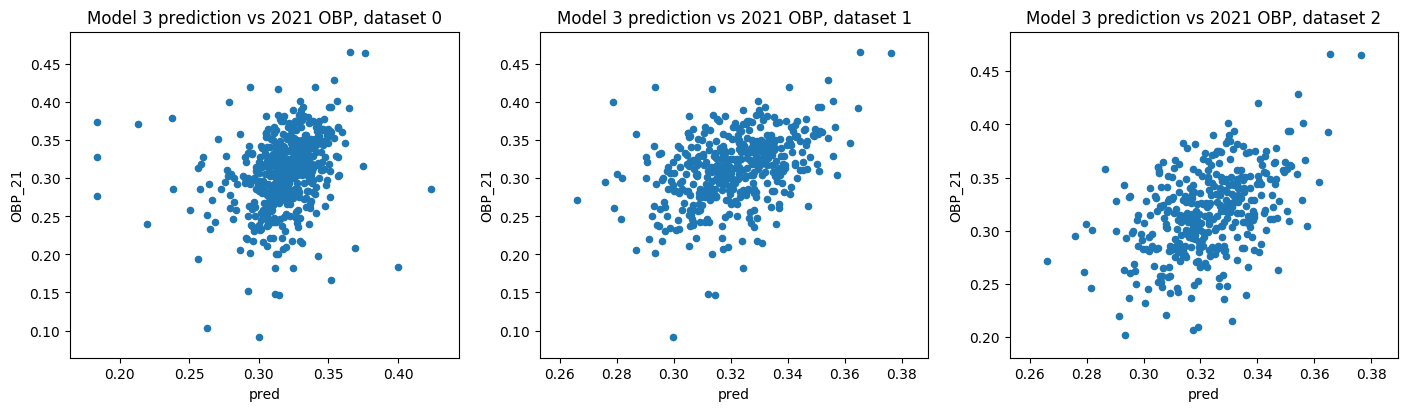

In [11]:
import sklearn.linear_model

def pa_slope(row):
    lr = sklearn.linear_model.LinearRegression()
    lr.fit(np.array(list(range(row.shape[0]))).reshape(-1, 1), row)
    slope = lr.coef_[0]
    return slope

interpolated = df.copy()
# interpolated['age_days'] = abs(interpolated['age_days'] - interpolated['age_days'].mean())

y_train = interpolated[['OBP_20']]
interpolated['OBP_total_train'] = pd.concat([df[f'PA_{year}'] * df[f'OBP_{year}'] for year in range(16, 20)],
                                         axis='columns').sum(axis='columns') \
                                  / df['PA_total']

for year in range(16, 20):
    year_slice = interpolated[f'PA_{year}'] < min_season_pa
    interpolated.loc[year_slice, f'OBP_{year}'] = interpolated.loc[year_slice, 'OBP_total_train']
    
feature_cols = [f'OBP{i}' for i in range(4)] + ['PA_slope']
train_slice = (interpolated['PA_20'] >= min_season_pa) & (pd.concat([interpolated[f'PA_{year}'] < min_season_pa for year in range(16, 20)], axis='columns').sum(axis='columns') <= 2)
X_train = interpolated.loc[train_slice,
                           [f'OBP_{year}' for year in range(16, 20)] + ['age_days']].dropna()
X_train['PA_slope'] = interpolated.loc[train_slice,
                                       [f'PA_{year}' for year in range(16, 20)]
                                      ].apply(pa_slope, axis='columns')
X_train.rename(columns={f'OBP_{year}' : f'OBP{i}' for i, year in enumerate(range(16, 20))}, inplace=True)
train = X_train.merge(y_train, left_index=True, right_index=True)
lr = sklearn.linear_model.Ridge(alpha=.1, fit_intercept=True).fit(X_train[feature_cols], train['OBP_20'])

for year in range(16, 21):
    year_slice = interpolated[f'PA_{year}'] < min_season_pa
    interpolated.loc[year_slice, f'OBP_{year}'] = interpolated.loc[year_slice, 'OBP_total']

test = interpolated.merge(df_2021, left_index=True, right_index=True)
test.rename(columns={f'OBP_{year}' : f'OBP{i}' for i, year in enumerate(range(17, 21))}, inplace=True)
test['PA_slope'] = test[[f'PA_{year}' for year in range(17, 21)]].apply(pa_slope, axis='columns')

subsets = [test.index, test['PA_total'] >= 100, (test['PA_total'] >= 100) & (test['PA_21'] >= 100)]

fig, ax = plt.subplots(ncols=3, figsize=(14, 4), constrained_layout=True)

model3_evals = []
for i, subset in enumerate(subsets):
    model3_res = test.loc[subset]
    model3_res['pred'] = lr.predict(model3_res[feature_cols])
    mae = mean_abs_error(model3_res['pred'], model3_res['OBP_21'])
    rmse = root_mean_squared_error(model3_res['pred'], model3_res['OBP_21'])
    model3_res.plot.scatter(x='pred', y='OBP_21', title=f'Model 3 prediction vs 2021 OBP, dataset {i}', ax=ax[i])
    model3_evals.append([i, mae, rmse, len(model3_res)])

In [12]:
model3_eval = pd.DataFrame(model3_evals, columns=eval_columns)
model3_eval['model'] = 3
results = pd.concat([model1_eval, model2_eval, model3_eval])[['model'] + eval_columns].sort_values('data_subset')
results

,model,data_subset,mean_absolute_error,root_mean_squared_error,count_data_points
0,1,0,0.043681,0.064201,506
0,2,0,0.036967,0.050799,506
0,3,0,0.036575,0.050087,506
1,1,1,0.034724,0.045534,431
1,2,1,0.032627,0.043265,431
1,3,1,0.032562,0.043278,431
2,1,2,0.030872,0.038872,381
2,2,2,0.028591,0.036229,381
2,3,2,0.028428,0.036052,381


## Conclusion

Each model's predictions improved upon the previous model, in terms of mean absolute error and root mean squared error, when measured against the target of 2021 OBP. Model 2's outperformance of Model 1 reflects strongly that more recent performance has higher predictive power over the following year's performance. Model 3's slight outperformance of Model 2 shows that suppressing outlier seasons may positively impact the prediction of OBP.

Text(0.5, 0.98, "Models' mean absolute error by dataset")

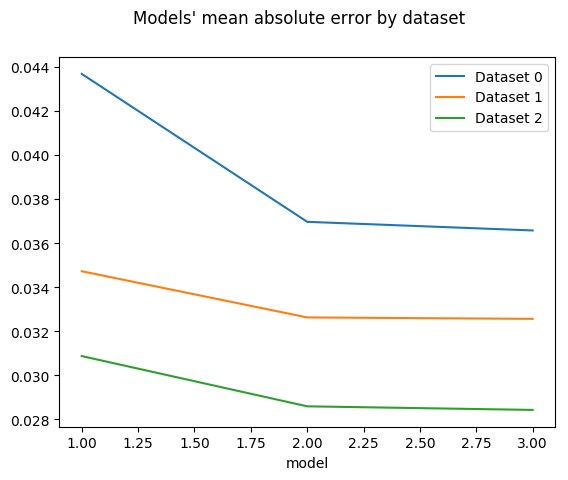

In [13]:
fig, ax = plt.subplots()
for i, (name, group) in enumerate(results.groupby('data_subset')):
    group.plot(x='model', y='mean_absolute_error', label=f'Dataset {i}', ax=ax)
plt.suptitle("Models' mean absolute error by dataset")

Text(0.5, 0.98, "Models' root mean squared error by dataset")

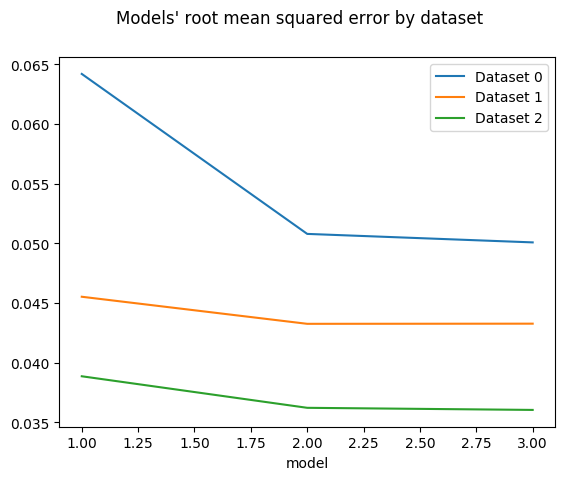

In [14]:
fig, ax = plt.subplots()
for i, (name, group) in enumerate(results.groupby('data_subset')):
    group.plot(x='model', y='root_mean_squared_error', label=f'Dataset {i}', ax=ax)
plt.suptitle("Models' root mean squared error by dataset")